In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

### 一、使用词嵌入进行电影评论分类

#### 1.利用 Embedding 层学习词嵌入

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  #最大特征数,即该训练集最常见的前10000个单词
maxlen = 20  #每条评论最大长度为20，超过将被截断

#将数据加载为整数列表
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train[0])

#整数列表填充处理:即超长截断、不足则前补0，默认从尾部截取，得到等长二维整数张量(samples,maxlen)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[  65   16   38 1334   88   12   16  283    5   16 4472  113

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense,Embedding

model = Sequential()
#添加embedding层，将10000个单词嵌入到维度为8的向量中，输入序列长度为20
model.add(Embedding(10000, 8, input_length=maxlen))
#将三维的嵌入张量展平成形状为(samples,maxlen*8)的二维张量
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 55us/step - loss: 0.6636 - acc: 0.6331 - val_loss: 0.6070 - val_acc: 0.6960
Epoch 2/10
20000/20000 [==============================] - 1s 33us/step - l

#### 2.使用预训练的词嵌入

下载 IMDB 数据的原始文本

In [4]:
import os

imdb_dir = 'D:/2021-2022学年 文件汇总/深度学习与应用实践/数据集/aclImdb_v1.tar/aclImdb_v1/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

对数据进行分词

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  #在100个单词后截断评论
training_samples = 200  #在200个样本上训练
validation_samples = 10000  #在10000个样本上验证
max_words = 10000  #只考虑数据集中前10000个最常见的单词

tokenizer = Tokenizer(num_words=max_words)  #建一个分词器（tokenizer），设置为只考虑前10000个最常见的单词
tokenizer.fit_on_texts(texts)  #构建单词索引
sequences = tokenizer.texts_to_sequences(texts)  #将字符串转换为整数索引组成的列表

word_index = tokenizer.word_index  #找回单词索引
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)  #整数列表填充处理，即超长截断、不足则前补0，默认从尾部截取

labels = np.asarray(labels)  #转换为张量数据
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 将数据划分为训练集和验证集，但首先要打乱数据，因为一开始数据中的样本是排好序的（所有负面评论都在前面， 然后是所有正面评论）
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


对嵌入进行预处理

In [16]:
#对txt文件解析，构建一个将单词（字符串）映射为其向量表示（数值向量）的索引

glove_dir = 'D:/2021-2022学年 文件汇总/深度学习与应用实践/数据集'

embeddings_index = {}  #定义字典
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))  #embeddings_index是字典形式，每个单词有100维嵌入词向量

Found 400000 word vectors.


In [23]:
#构建一个可以加载到 Embedding 层中的嵌入矩阵，形状为(max_words, embedding_dim)
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # 嵌入索引（embeddings_index） 中找不到的词，其嵌入向量全为 0
            embedding_matrix[i] = embedding_vector

定义模型

In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


在模型中加载 GloVe 嵌入

In [35]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False  #冻结Embedding 层

编译并训练模型

In [36]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 1.5956 - acc: 0.5350 - val_loss: 0.7074 - val_acc: 0.5082
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8488 - acc: 0.5400 - val_loss: 0.6969 - val_acc: 0.5261
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4794 - acc: 0.7850 - val_loss: 1.2345 - val_acc: 0.4983
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5237 - acc: 0.7100 - val_loss: 0.7420 - val_acc: 0.5396
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2816 - acc: 0.9050 - val_loss: 1.9348 - val_acc: 0.5062
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3961 - acc: 0.8550 - val_loss: 0.7321 - val_acc: 0.5659
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0990 - acc: 1.0000 - val_loss: 0.8644 - val_acc: 0.5319
Epoch 8/10
200/200 [=======

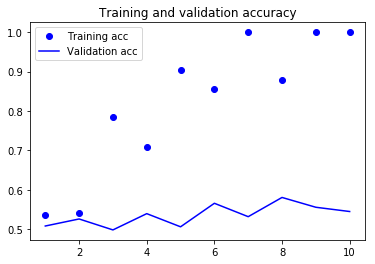

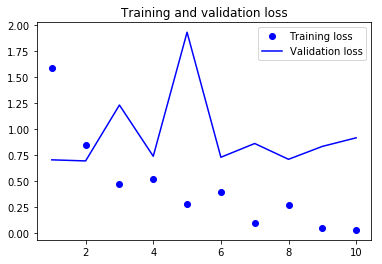

In [38]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

导入测试集，并进行分词

In [42]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

在测试集中评估模型性能

In [43]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 57us/step


[0.9379357239985466, 0.5376799702644348]

### 二、使用RNN实现电影评论分类

读取数据并进行预处理

In [44]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  #最大特征数,即该训练集最常见的前10000个单词
maxlen = 20  #每条评论最大长度为20，超过将被截断

#将数据加载为整数列表
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train[0])

#整数列表填充处理:即超长截断、不足则前补0，默认从尾部截取，得到等长二维整数张量(samples,maxlen)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[  65   16   38 1334   88   12   16  283    5   16 4472  113

LSTM

In [46]:
from keras.layers import Dense,LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 9s 440us/step - loss: 0.5794 - acc: 0.6899 - val_loss: 0.5290 - val_acc: 0.7318
Epoch 2/10
20000/20000 [==============================] - 6s 304us/step - loss: 0.4447 - acc: 0.7916 - val_loss: 0.4908 - val_acc: 0.7450
Epoch 3/10
20000/20000 [==============================] - 6s 306us/step - loss: 0.3960 - acc: 0.8206 - val_loss: 0.5253 - val_acc: 0.7514
Epoch 4/10
20000/20000 [==============================] - 6s 304us/step - loss: 0.3672 - acc: 0.8378 - val_loss: 0.5202 - val_acc: 0.7526
Epoch 5/10
20000/20000 [==============================] - 6s 312us/step - loss: 0.3467 - acc: 0.8490 - val_loss: 0.5098 - val_acc: 0.7526
Epoch 6/10
20000/20000 [==============================] - 6s 316us/step - loss: 0.3300 - acc: 0.8577 - val_loss: 0.5244 - val_acc: 0.7466
Epoch 7/10
20000/20000 [==============================] - 6s 315us/step - loss: 0.3138 - acc: 0.8647 - val_loss: 0.5521 - v

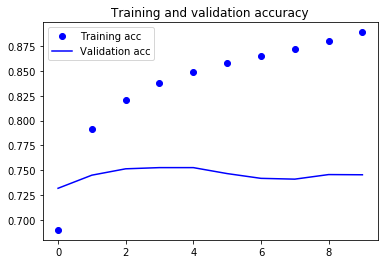

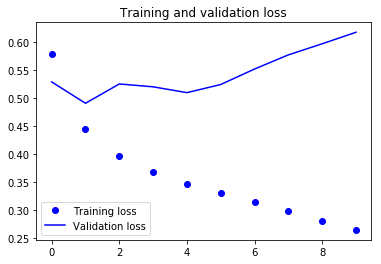

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

堆叠LSTM

In [49]:
from keras.layers import Dense,LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32,dropout=0.1,return_sequences=True))  #输出全部序列
model.add(LSTM(32,dropout=0.1,return_sequences=True))  #输出全部序列
model.add(LSTM(32,dropout=0.1))  #最后一个LSTM只输出一个输出
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 344,993
Trainable params: 344,993
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 23s 1ms

BiLSTM

In [51]:
from keras.layers import Dense,LSTM,Bidirectional

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 611us/step - loss: 0.5526 - acc: 0.7117 - val_loss: 0.5056 - val_acc: 0.7474
Epoch 2/10
20000/20000 [==============================] - 8s 397us/step - loss: 0.4280 - acc: 0.8033 - val_loss: 0.4956 - val_acc: 0.7518
Epoch 3/10
20000/20000 [============================